In [1]:
from google.colab import drive
drive.mount('/content/drive')

import sys
FOLDERNAME='ML_final_project'
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
! pip install mlflow
!pip install dagshub

In [3]:
!pip install dagshub mlflow -q

import dagshub
import mlflow
import mlflow.lightgbm
import mlflow.sklearn
from mlflow.tracking import MlflowClient
from mlflow.exceptions import MlflowException
from mlflow.entities import Experiment
from mlflow.entities.lifecycle_stage import LifecycleStage

dagshub.init(repo_owner='skara-21', repo_name='ML_Final_Project', mlflow=True)

mlflow.set_tracking_uri('https://dagshub.com/skara-21/ML_Final_Project.mlflow')

client = MlflowClient()
experiment_name = "ARIMA_Training"

try:
    experiment = client.get_experiment_by_name(experiment_name)
    if experiment:
        if experiment.lifecycle_stage == LifecycleStage.DELETED:
            print(f"Experiment '{experiment_name}' is deleted. Attempting to restore...")
            try:
                client.restore_experiment(experiment.experiment_id)
                print(f"Experiment '{experiment_name}' restored.")
            except Exception as e:
                print(f"Failed to restore experiment: {e}. Permanently deleting...")
                client.delete_experiment(experiment.experiment_id, True)
                print(f"Experiment '{experiment_name}' permanently deleted.")
                experiment = None


    if experiment is None:
        experiment_id = client.create_experiment(experiment_name)
        print(f"Experiment '{experiment_name}' created with ID: {experiment_id}")
    else:
        mlflow.set_experiment(experiment_name)
        experiment_id = experiment.experiment_id
        print(f"Experiment '{experiment_name}' set with ID: {experiment_id}")

except MlflowException as e:
    print(f"An MLflow error occurred: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Accessing as skara-21

Initialized MLflow to track repo "skara-21/ML_Final_Project"

Repository skara-21/ML_Final_Project initialized!

Experiment 'ARIMA_Training' set with ID: 3


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.diagnostic import acorr_ljungbox

import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature
import joblib

from scripts.time_series_utils import *

In [5]:
def decompose_and_deseasonalize(ts_data, period=52):
    from statsmodels.tsa.seasonal import seasonal_decompose

    periods_to_try = [52, 26, 13, 4]

    for p in periods_to_try:
        min_required = p * 2

        if len(ts_data) >= min_required:
            try:
                decomposition = seasonal_decompose(ts_data['Weekly_Sales'], period=p, model='additive')

                deseasonalized = ts_data['Weekly_Sales'] - decomposition.seasonal
                seasonal_component = decomposition.seasonal

                deseasonalized_data = ts_data.copy()
                deseasonalized_data['Weekly_Sales'] = deseasonalized
                deseasonalized_data['Weekly_Sales_Original'] = ts_data['Weekly_Sales']

                print(f"  Used seasonal period {p} for decomposition")
                return deseasonalized_data, seasonal_component, decomposition

            except Exception as e:
                continue

    print(f"  No suitable seasonal period found - proceeding without deseasonalization")
    return ts_data, None, None

In [6]:
class ARIMAModel:
    def __init__(self, order=(1,1,1), use_deseasonalization=True, seasonal_period=52):
        self.order = order
        self.use_deseasonalization = use_deseasonalization
        self.seasonal_period = seasonal_period
        self.model = None
        self.fitted_model = None
        self.aic = None
        self.bic = None
        self.fitted = False
        self.seasonal_component = None
        self.decomposition = None

    def fit(self, ts_data):
        try:
            if self.use_deseasonalization:
                deseasonalized_data, seasonal_component, decomposition = decompose_and_deseasonalize(
                    ts_data, self.seasonal_period
                )
                self.seasonal_component = seasonal_component
                self.decomposition = decomposition
                training_data = deseasonalized_data['Weekly_Sales']

                if seasonal_component is None:
                    training_data = ts_data['Weekly_Sales']
            else:
                training_data = ts_data['Weekly_Sales']

            self.model = ARIMA(training_data, order=self.order)
            self.fitted_model = self.model.fit()
            self.aic = self.fitted_model.aic
            self.bic = self.fitted_model.bic
            self.fitted = True
            return self

        except Exception as e:
            print(f"error fitting ARIMA{self.order}: {e}")
            self.fitted = False
            return None

    def predict(self, steps):
        if not self.fitted or self.fitted_model is None:
            raise ValueError("Model not fitted yet")

        forecast = self.fitted_model.forecast(steps=steps)

        if self.use_deseasonalization and self.seasonal_component is not None:
            forecast_start_idx = len(self.fitted_model.fittedvalues) % self.seasonal_period
            forecast = reseasonalize_forecast(forecast, self.seasonal_component, forecast_start_idx)

        return forecast

    def get_model_summary(self):
        if self.fitted_model is None:
            return None
        return self.fitted_model.summary()

    def get_residuals(self):
        if self.fitted_model is None:
            return None
        return self.fitted_model.resid

    def diagnostic_tests(self):
        if self.fitted_model is None:
            return None

        residuals = self.fitted_model.resid

        lb_test = acorr_ljungbox(residuals, lags=10, return_df=True)

        jb_test = self.fitted_model.test_normality(method='jarquebera')

        return {
            'ljung_box': lb_test,
            'jarque_bera': jb_test,
            'residual_mean': residuals.mean(),
            'residual_std': residuals.std()
        }

In [7]:
def reseasonalize_forecast(forecast, seasonal_component, forecast_start_idx):
    if seasonal_component is None:
        return forecast

    try:
        seasonal_pattern = seasonal_component.iloc[forecast_start_idx:forecast_start_idx + len(forecast)]

        if len(seasonal_pattern) < len(forecast):
            full_cycle = seasonal_component.dropna()
            seasonal_pattern = []
            for i in range(len(forecast)):
                seasonal_pattern.append(full_cycle.iloc[i % len(full_cycle)])
            seasonal_pattern = pd.Series(seasonal_pattern)

        reseasonalized = forecast + seasonal_pattern.values[:len(forecast)]

        return reseasonalized

    except Exception as e:
        print(f"error in reseasonalization: {e}")
        return forecast

In [8]:
def arima_grid_search(ts_data, p_values, d_values, q_values, verbose=False):
    best_aic = float('inf')
    best_order = None
    best_model = None
    results = []

    total_combinations = len(p_values) * len(d_values) * len(q_values)
    current_combination = 0

    for p in p_values:
        for d in d_values:
            for q in q_values:
                current_combination += 1

                try:
                    if verbose:
                        print(f"testing ARIMA({p},{d},{q}) - {current_combination}/{total_combinations}")

                    model = ARIMAModel(order=(p,d,q))
                    fitted_model = model.fit(ts_data)

                    if fitted_model is not None and fitted_model.fitted:
                        aic = fitted_model.aic
                        bic = fitted_model.bic

                        results.append({
                            'p': p,
                            'd': d,
                            'q': q,
                            'order': f"({p},{d},{q})",
                            'aic': aic,
                            'bic': bic
                        })

                        if aic < best_aic:
                            best_aic = aic
                            best_order = (p,d,q)
                            best_model = fitted_model

                        if verbose:
                            print(f"  ✓ AIC: {aic:.2f}, BIC: {bic:.2f}")

                except Exception as e:
                    if verbose:
                        print(f"  ✗ Error: {e}")
                    continue

    print(f"grid search completed!")
    print(f"best ARIMA order: {best_order}")
    print(f"best AIC: {best_aic:.2f}")

    return best_model, best_order, best_aic, pd.DataFrame(results)

In [9]:
class ARIMAPipeline:
    def __init__(self, store_id=1, dept_id=1, arima_order=(1,1,1), use_deseasonalization=True, seasonal_period=52):
        self.store_id = store_id
        self.dept_id = dept_id
        self.arima_order = arima_order
        self.use_deseasonalization = use_deseasonalization
        self.seasonal_period = seasonal_period
        self.preprocessor = TimeSeriesPreprocessor(store_id, dept_id)
        self.model = ARIMAModel(arima_order, use_deseasonalization, seasonal_period)
        self.fitted = False

    def fit(self, train_df, stores_df=None, features_df=None):
        self.ts_data = self.preprocessor.transform(train_df)

        fitted_model = self.model.fit(self.ts_data)

        if fitted_model is not None:
            self.fitted = True
            return self
        else:
            self.fitted = False
            return None

    def predict(self, steps):
        if not self.fitted:
            raise ValueError("pipeline not fitted yet")

        return self.model.predict(steps)

    def get_model_info(self):
        if not self.fitted:
            return None

        return {
            'store_id': self.store_id,
            'dept_id': self.dept_id,
            'arima_order': self.arima_order,
            'use_deseasonalization': self.use_deseasonalization,
            'seasonal_period': self.seasonal_period,
            'aic': self.model.aic,
            'bic': self.model.bic,
            'has_seasonal_component': self.model.seasonal_component is not None
        }

🏃 View run ARIMA_Data_Loading at: https://dagshub.com/skara-21/ML_Final_Project.mlflow/#/experiments/3/runs/62ac51964d0a4501b2446306cc108319
🧪 View experiment at: https://dagshub.com/skara-21/ML_Final_Project.mlflow/#/experiments/3
🏃 View run ARIMA_Preprocessing at: https://dagshub.com/skara-21/ML_Final_Project.mlflow/#/experiments/3/runs/04391fd73c19432da3588da7edd7cbdb
🧪 View experiment at: https://dagshub.com/skara-21/ML_Final_Project.mlflow/#/experiments/3


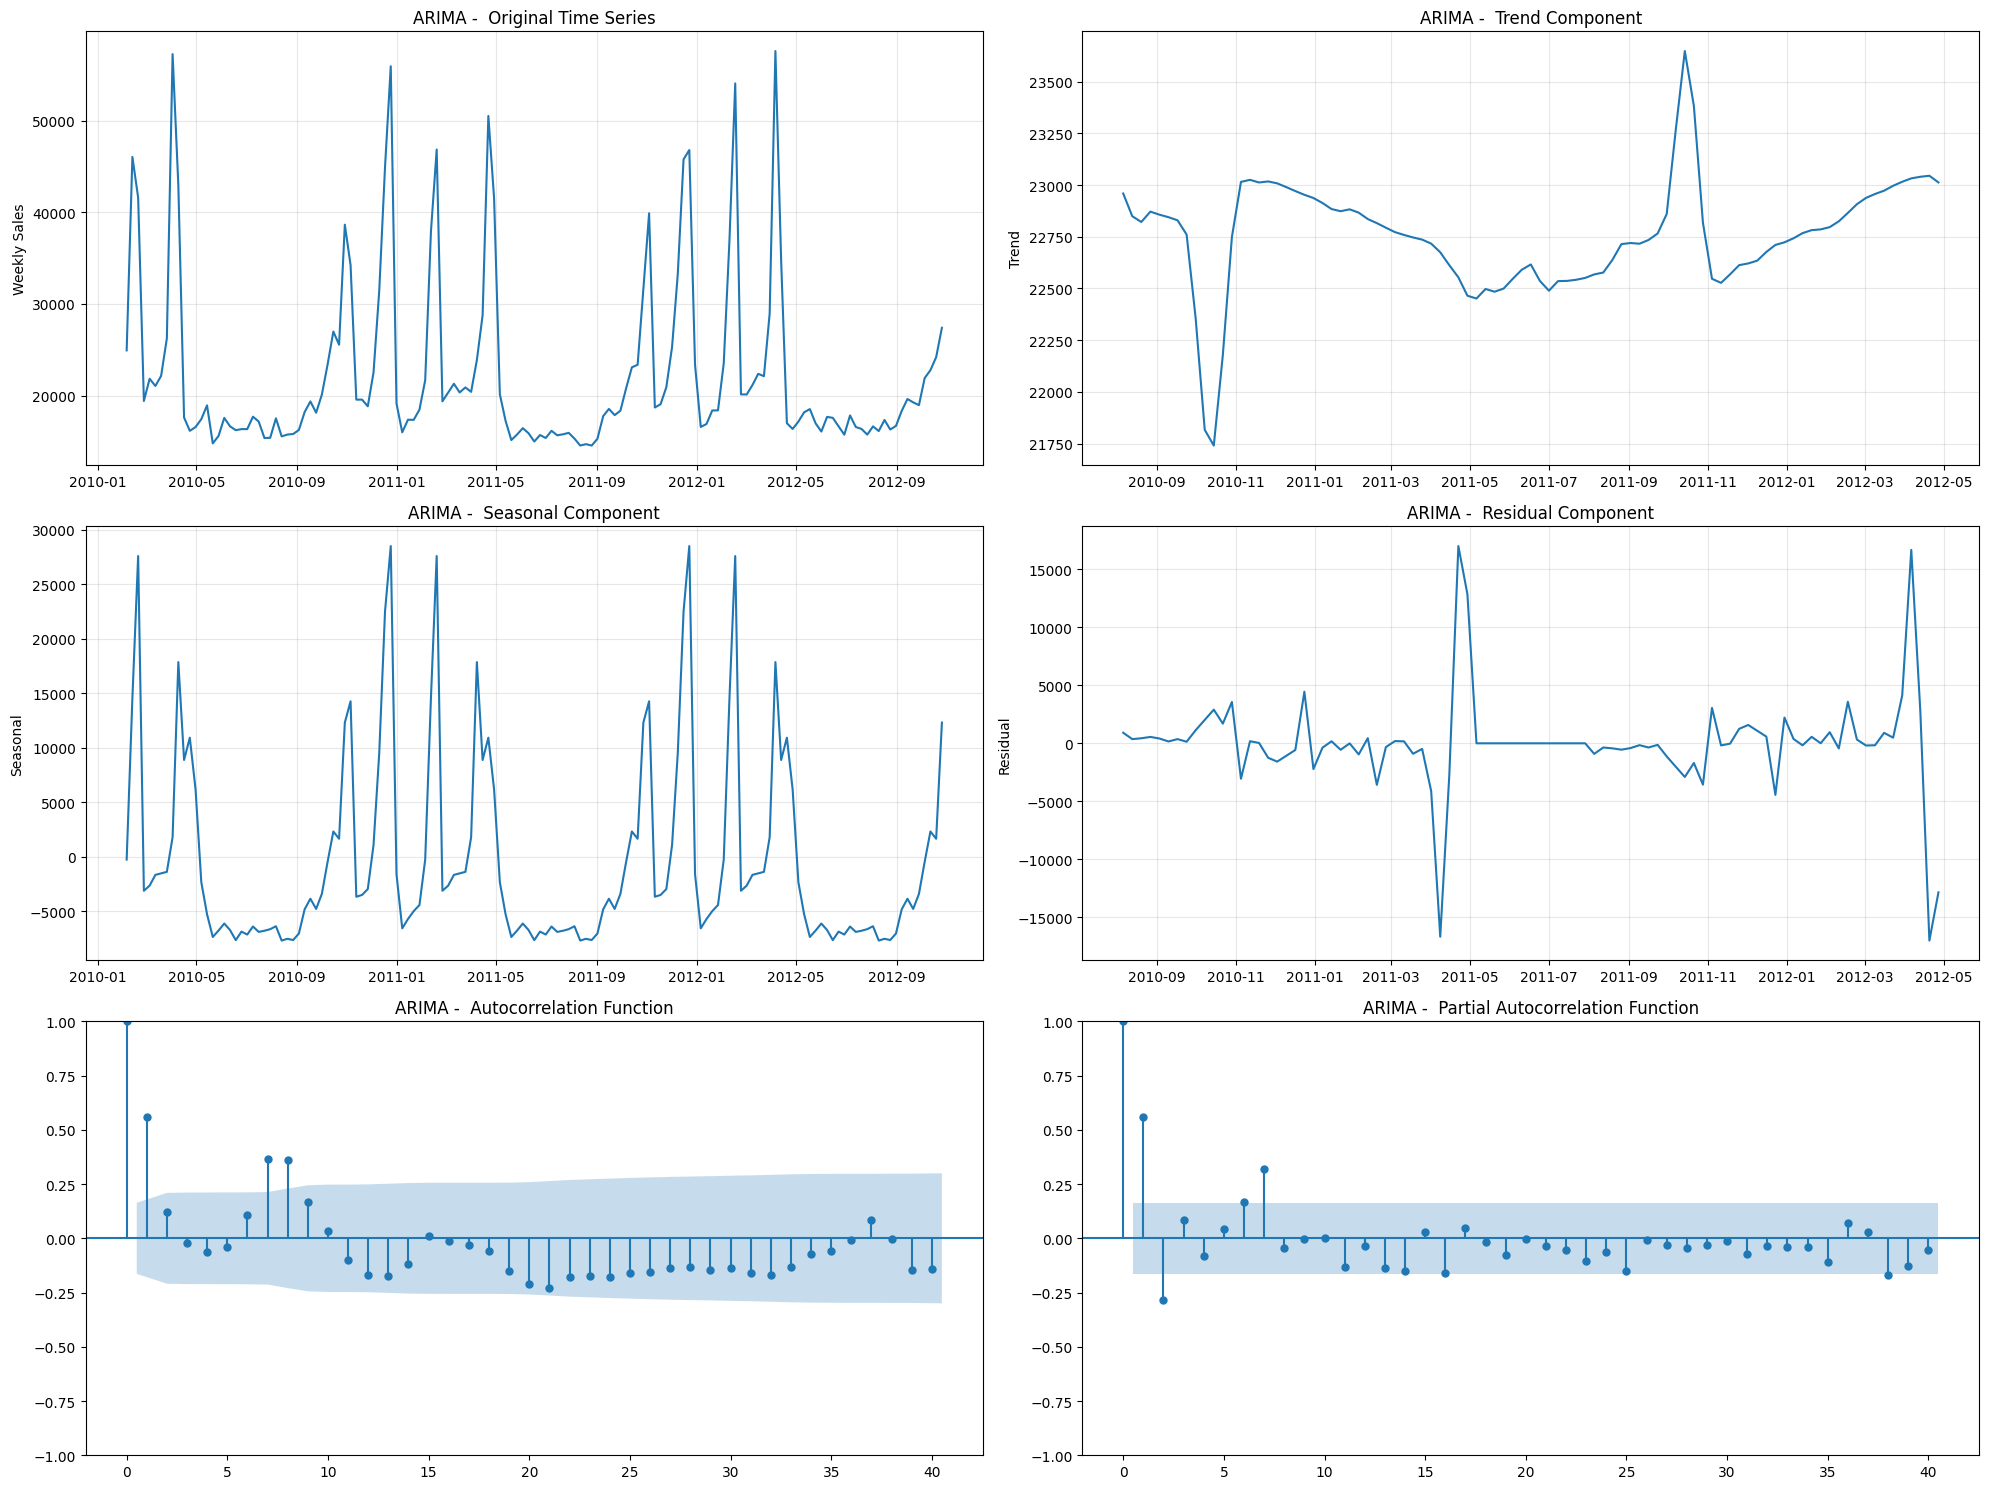

  Used seasonal period 52 for decomposition


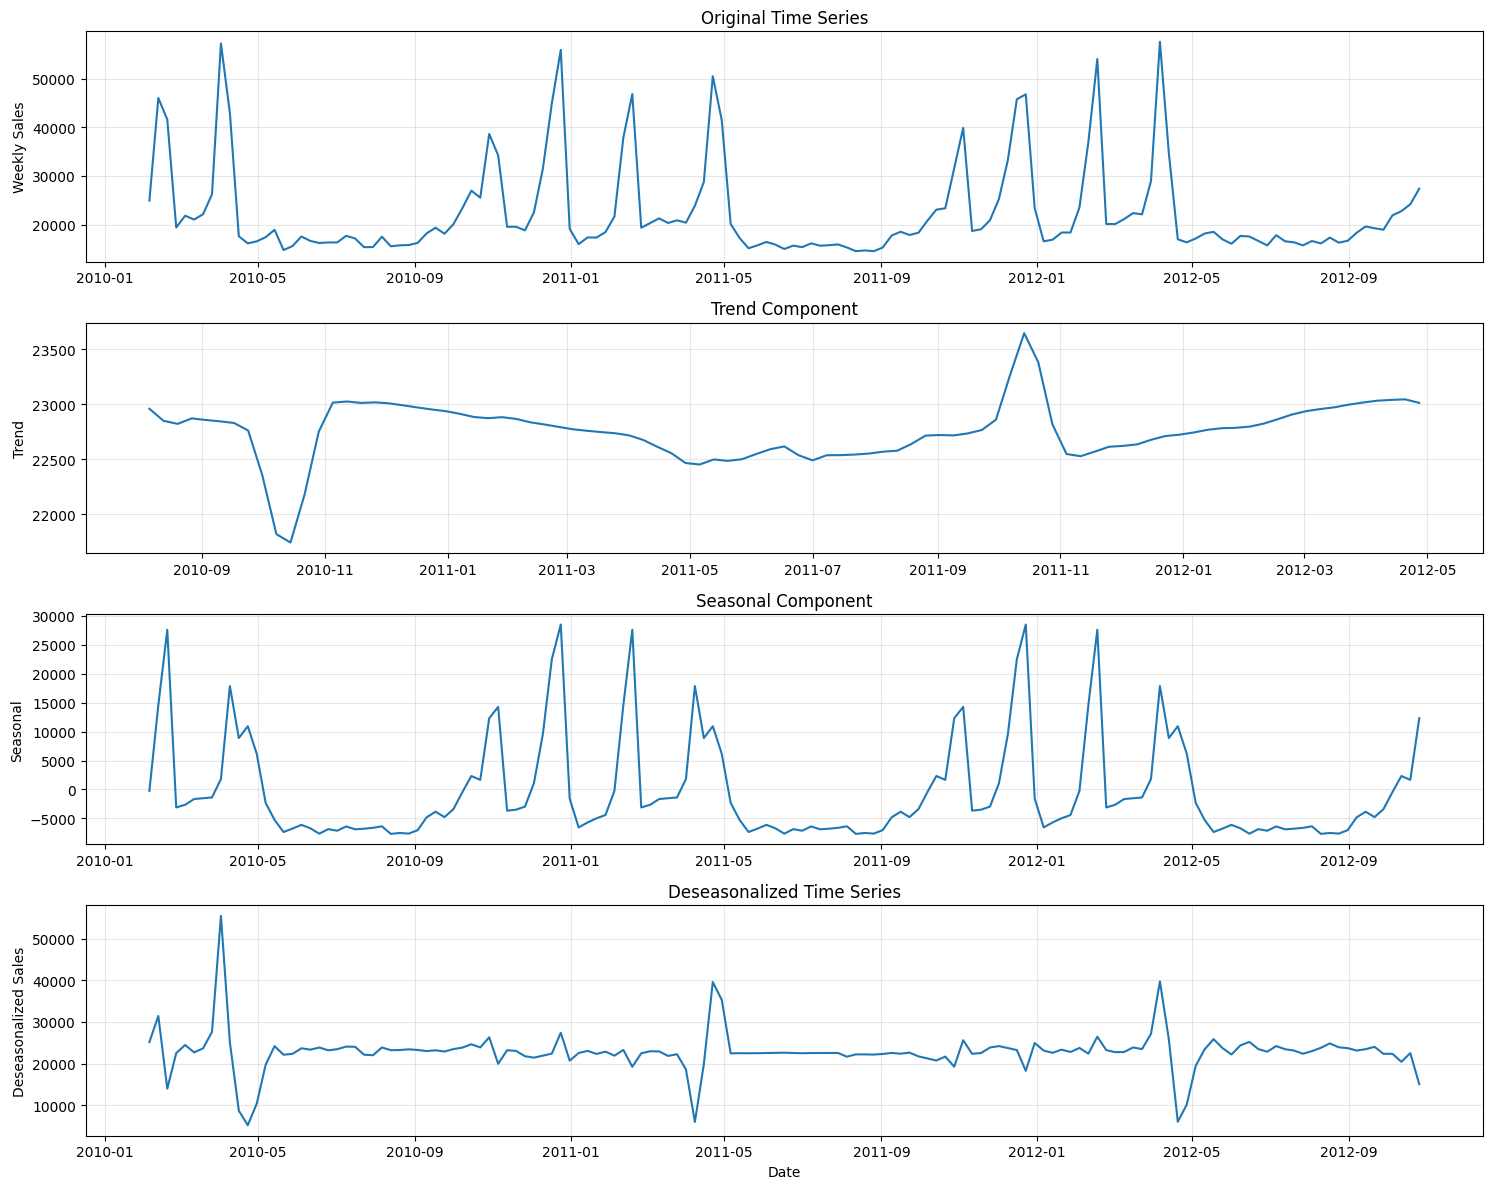

seasonal strength: 0.7355
trend strength: 0.0038
🏃 View run ARIMA_Time_Series_Analysis at: https://dagshub.com/skara-21/ML_Final_Project.mlflow/#/experiments/3/runs/5b4781cd96434046a1e346e7800b0b15
🧪 View experiment at: https://dagshub.com/skara-21/ML_Final_Project.mlflow/#/experiments/3
  Used seasonal period 52 for decomposition
  Used seasonal period 52 for decomposition
  Used seasonal period 52 for decomposition
  Used seasonal period 52 for decomposition
  Used seasonal period 52 for decomposition
  Used seasonal period 52 for decomposition
  Used seasonal period 52 for decomposition
  Used seasonal period 52 for decomposition
  Used seasonal period 52 for decomposition
  Used seasonal period 52 for decomposition
  Used seasonal period 52 for decomposition
  Used seasonal period 52 for decomposition
  Used seasonal period 52 for decomposition
  Used seasonal period 52 for decomposition
  Used seasonal period 52 for decomposition
  Used seasonal period 52 for decomposition
  Used 

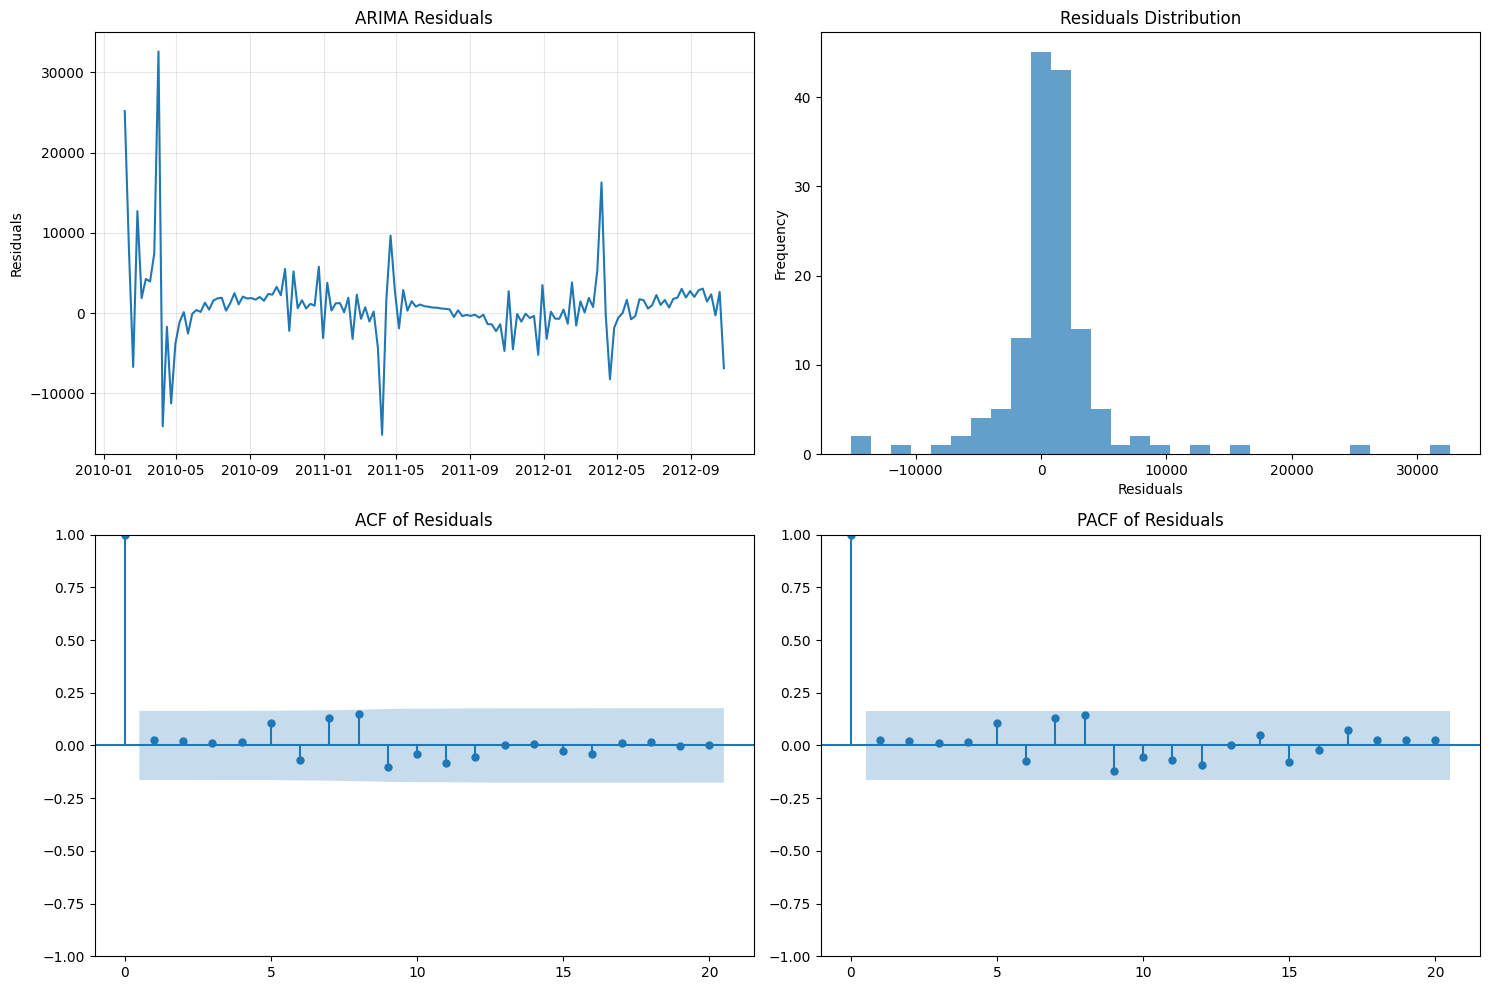

🏃 View run ARIMA_Training_Evaluation at: https://dagshub.com/skara-21/ML_Final_Project.mlflow/#/experiments/3/runs/f3b2411a4c0f4d6f9d962ceebddabb01
🧪 View experiment at: https://dagshub.com/skara-21/ML_Final_Project.mlflow/#/experiments/3
  Used seasonal period 52 for decomposition
  Used seasonal period 52 for decomposition
  Used seasonal period 26 for decomposition
  Used seasonal period 26 for decomposition
  Used seasonal period 26 for decomposition
Cross-Validation Results:
cv_mae: 5740.0411
cv_mae_std: 2149.5129
cv_mse: 98666718.2366
cv_mse_std: 58539288.8724
cv_rmse: 9178.4129
cv_rmse_std: 3797.8225
cv_mape: 24.7908
cv_mape_std: 11.7268
🏃 View run ARIMA_Cross_Validation at: https://dagshub.com/skara-21/ML_Final_Project.mlflow/#/experiments/3/runs/6bfb2a568dca4895a56318eefe001443
🧪 View experiment at: https://dagshub.com/skara-21/ML_Final_Project.mlflow/#/experiments/3
  Used seasonal period 52 for decomposition
final ARIMA pipeline created successfully!
final model info:
store_

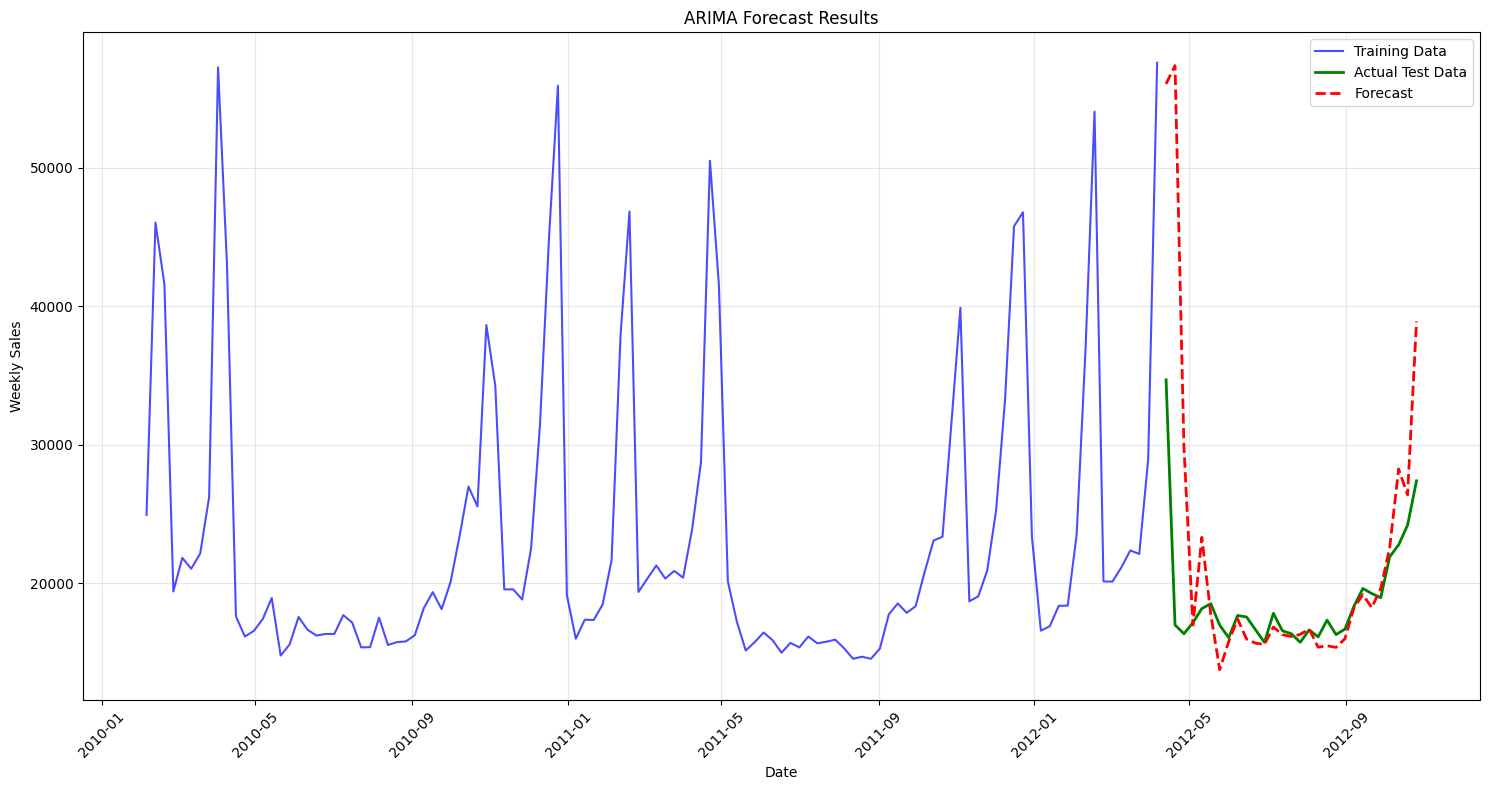

Successfully registered model 'ARIMA_Store_1_Dept_1'.


Failed to register model: INTERNAL_ERROR: Response: {'error': 'unsupported endpoint, please contact support@dagshub.com'}
🏃 View run ARIMA_Final_Model at: https://dagshub.com/skara-21/ML_Final_Project.mlflow/#/experiments/3/runs/6f4a3177b5fc4684af92c228712f5135
🧪 View experiment at: https://dagshub.com/skara-21/ML_Final_Project.mlflow/#/experiments/3


In [10]:
STORE_ID = 1
DEPT_ID = 1

with mlflow.start_run(run_name="ARIMA_Data_Loading"):
    train_df, test_df, stores_df, features_df = load_walmart_data()

    stats = explore_data(train_df, test_df, stores_df, features_df)

    for key, value in stats.items():
        mlflow.log_metric(key, value)

    mlflow.log_param("store_id", STORE_ID)
    mlflow.log_param("dept_id", DEPT_ID)
    mlflow.log_param("model_type", "ARIMA")
    mlflow.log_param("use_deseasonalization", True)
    mlflow.log_param("seasonal_period", 52)
mlflow.end_run()


with mlflow.start_run(run_name="ARIMA_Preprocessing"):
    ts_data = prepare_time_series_data(train_df, stores_df, features_df, STORE_ID, DEPT_ID)

    mlflow.log_metric("ts_data_points", len(ts_data))
    mlflow.log_metric("ts_weeks", len(ts_data))

    sales_stats = ts_data['Weekly_Sales'].describe()
    for stat_name, stat_value in sales_stats.items():
        clean_stat_name = stat_name.replace('%', 'pct')
        mlflow.log_metric(f"sales_{clean_stat_name}", stat_value)

    missing_values = ts_data['Weekly_Sales'].isnull().sum()
    mlflow.log_metric("missing_values", missing_values)
mlflow.end_run()

with mlflow.start_run(run_name="ARIMA_Time_Series_Analysis"):
    plot_time_series_analysis(ts_data, "ARIMA - ")

    deseasonalized_data, seasonal_component, decomposition = decompose_and_deseasonalize(ts_data, 52)

    if decomposition is not None:
        fig, axes = plt.subplots(4, 1, figsize=(15, 12))

        axes[0].plot(ts_data.index, ts_data['Weekly_Sales'])
        axes[0].set_title('Original Time Series')
        axes[0].set_ylabel('Weekly Sales')
        axes[0].grid(True, alpha=0.3)

        axes[1].plot(decomposition.trend.index, decomposition.trend)
        axes[1].set_title('Trend Component')
        axes[1].set_ylabel('Trend')
        axes[1].grid(True, alpha=0.3)

        axes[2].plot(decomposition.seasonal.index, decomposition.seasonal)
        axes[2].set_title('Seasonal Component')
        axes[2].set_ylabel('Seasonal')
        axes[2].grid(True, alpha=0.3)

        axes[3].plot(deseasonalized_data.index, deseasonalized_data['Weekly_Sales'])
        axes[3].set_title('Deseasonalized Time Series')
        axes[3].set_ylabel('Deseasonalized Sales')
        axes[3].set_xlabel('Date')
        axes[3].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        seasonal_strength = np.var(decomposition.seasonal.dropna()) / np.var(decomposition.seasonal.dropna() + decomposition.resid.dropna())
        trend_strength = np.var(decomposition.trend.dropna()) / np.var(decomposition.trend.dropna() + decomposition.resid.dropna())

        print(f"seasonal strength: {seasonal_strength:.4f}")
        print(f"trend strength: {trend_strength:.4f}")

        mlflow.log_metric("seasonal_strength", seasonal_strength)
        mlflow.log_metric("trend_strength", trend_strength)
        mlflow.log_param("seasonal_decomposition_success", True)
    else:
        print("seasonal decomposition failed!")
        mlflow.log_param("seasonal_decomposition_success", False)

    stationarity_results = check_stationarity(ts_data['Weekly_Sales'], "Stationarity Test for ARIMA")

    for key, value in stationarity_results.items():
        if isinstance(value, bool):
            mlflow.log_metric(key, int(value))
        else:
            mlflow.log_metric(key, value)

    d_value = 0
    if not stationarity_results['adf_stationary']:
        ts_data['Weekly_Sales_diff'] = ts_data['Weekly_Sales'].diff()
        d_value = 1

        diff_results = check_stationarity(
            ts_data['Weekly_Sales_diff'].dropna(),
            "Stationarity Test After First Differencing"
        )

        for key, value in diff_results.items():
            if isinstance(value, bool):
                mlflow.log_metric(f"diff_{key}", int(value))
            else:
                mlflow.log_metric(f"diff_{key}", value)

        if not diff_results['adf_stationary']:
            ts_data['Weekly_Sales_diff2'] = ts_data['Weekly_Sales_diff'].diff()
            d_value = 2

            diff2_results = check_stationarity(
                ts_data['Weekly_Sales_diff2'].dropna(),
                "Stationarity Test After Second Differencing"
            )

    mlflow.log_param("suggested_d_value", d_value)
mlflow.end_run()

with mlflow.start_run(run_name="ARIMA_Parameter_Selection"):
    p_values = range(0, 5)
    d_values = range(0, 3)
    q_values = range(0, 5)

    mlflow.log_param("p_range", str(list(p_values)))
    mlflow.log_param("d_range", str(list(d_values)))
    mlflow.log_param("q_range", str(list(q_values)))

    best_arima, best_arima_order, best_arima_aic, arima_results = arima_grid_search(
        ts_data, p_values, d_values, q_values
    )

    if best_arima is not None:
        print(f"best ARIMA model: {best_arima_order}")
        print(f"best AIC: {best_arima_aic:.2f}")
        print(f"best BIC: {best_arima.bic:.2f}")

        mlflow.log_param("best_arima_order", str(best_arima_order))
        mlflow.log_param("best_p", best_arima_order[0])
        mlflow.log_param("best_d", best_arima_order[1])
        mlflow.log_param("best_q", best_arima_order[2])
        mlflow.log_metric("best_arima_aic", best_arima_aic)
        mlflow.log_metric("best_arima_bic", best_arima.bic)

        print("top 5 ARIMA models by AIC:")
        top_models = arima_results.nsmallest(5, 'aic')
        print(top_models)

    else:
        print("no successful ARIMA model found!")

    arima_results_path = "arima_grid_search_results.csv"
    arima_results.to_csv(arima_results_path, index=False)
    mlflow.log_artifact(arima_results_path)
mlflow.end_run()

with mlflow.start_run(run_name="ARIMA_Training_Evaluation"):

    if best_arima is not None:

        print("ARIMA model summary:")
        print(best_arima.get_model_summary())

        diagnostics = best_arima.diagnostic_tests()

        mlflow.log_metric("residual_mean", diagnostics['residual_mean'])
        mlflow.log_metric("residual_std", diagnostics['residual_std'])

        lb_results = diagnostics['ljung_box'].head()

        first_lag_pvalue = diagnostics['ljung_box'].iloc[0]['lb_pvalue']
        mlflow.log_metric("ljungbox_pvalue_lag1", first_lag_pvalue)

        residuals = best_arima.get_residuals()

        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        axes[0,0].plot(residuals.index, residuals)
        axes[0,0].set_title('ARIMA Residuals')
        axes[0,0].set_ylabel('Residuals')
        axes[0,0].grid(True, alpha=0.3)

        axes[0,1].hist(residuals.dropna(), bins=30, alpha=0.7)
        axes[0,1].set_title('Residuals Distribution')
        axes[0,1].set_xlabel('Residuals')
        axes[0,1].set_ylabel('Frequency')

        from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
        plot_acf(residuals.dropna(), lags=20, ax=axes[1,0])
        axes[1,0].set_title('ACF of Residuals')

        plot_pacf(residuals.dropna(), lags=20, ax=axes[1,1])
        axes[1,1].set_title('PACF of Residuals')

        plt.tight_layout()
        plt.show()

    else:
        print("cannot proceed with evaluation - no successful ARIMA model!")
mlflow.end_run()

with mlflow.start_run(run_name="ARIMA_Cross_Validation"):
    if best_arima is not None:

        cv_results = perform_cross_validation(
            ts_data,
            ARIMAModel,
            {'order': best_arima_order},
            n_splits=5
        )

        if cv_results is not None:
            print("Cross-Validation Results:")
            for metric, value in cv_results.items():
                print(f"{metric}: {value:.4f}")
                mlflow.log_metric(metric, value)
        else:
            print("Cross-validation failed!")

    else:
        print("Cannot perform cross-validation - no successful ARIMA model!")
mlflow.end_run()

with mlflow.start_run(run_name="ARIMA_Final_Model"):
    if best_arima is not None:

        final_pipeline = ARIMAPipeline(
            store_id=STORE_ID,
            dept_id=DEPT_ID,
            arima_order=best_arima_order
        )

        fitted_pipeline = final_pipeline.fit(train_df, stores_df, features_df)

        if fitted_pipeline is not None:
            print("final ARIMA pipeline created successfully!")

            model_info = fitted_pipeline.get_model_info()
            print("final model info:")
            for key, value in model_info.items():
                print(f"{key}: {value}")
                mlflow.log_param(f"final_{key}", value)

            train_data, test_data = time_series_train_test_split(ts_data, test_size=0.2)



            train_pipeline = ARIMAPipeline(
                store_id=STORE_ID,
                dept_id=DEPT_ID,
                arima_order=best_arima_order
            )

            train_df_subset = train_df[
                (train_df['Store'] == STORE_ID) &
                (train_df['Dept'] == DEPT_ID) &
                (pd.to_datetime(train_df['Date']).isin(train_data.index))
            ]

            fitted_train_pipeline = train_pipeline.fit(train_df_subset, stores_df, features_df)

            if fitted_train_pipeline is not None:
                forecast = fitted_train_pipeline.predict(len(test_data))

                metrics = calculate_metrics(test_data['Weekly_Sales'].values, forecast)

                print("ARIMA test set performance:")
                for metric, value in metrics.items():
                    print(f"{metric}: {value:.4f}")
                    mlflow.log_metric(f"test_{metric.lower()}", value)

                plot_forecast_results(
                    train_data,
                    test_data,
                    forecast,
                    "ARIMA Forecast Results"
                )

                model_path = "arima_model.joblib"
                joblib.dump(fitted_pipeline, model_path)
                mlflow.log_artifact(model_path)

                model_uri = f"runs:/{mlflow.active_run().info.run_id}/{model_path}"
                model_name = f"ARIMA_Store_{STORE_ID}_Dept_{DEPT_ID}"

                try:
                    mlflow.register_model(model_uri, model_name)
                    print(f"model registered as '{model_name}' in MLflow Model Registry")
                    mlflow.log_param("registered_model_name", model_name)
                except Exception as e:
                    print(f"Failed to register model: {e}")

                forecast_df = pd.DataFrame({
                    'Date': test_data.index,
                    'Actual': test_data['Weekly_Sales'].values,
                    'Forecast': forecast
                })

                forecast_path = "arima_forecast_results.csv"
                forecast_df.to_csv(forecast_path, index=False)
                mlflow.log_artifact(forecast_path)

            else:
                print("failed to fit training pipeline!")
        else:
            print("failed to create final pipeline!")
    else:
        print("cannot create final model - no successful ARIMA model!")
mlflow.end_run()

In [11]:
import mlflow
with mlflow.start_run(run_name="ARIMA_Full_Submission"):
    test_df['Date'] = pd.to_datetime(test_df['Date'])

    test_combinations = test_df[['Store', 'Dept']].drop_duplicates()

    submission_list = []
    failed_combinations = []

    for idx, (_, row) in enumerate(test_combinations.iterrows()):
        store_id = row['Store']
        dept_id = row['Dept']


        try:
            test_subset = test_df[(test_df['Store'] == store_id) & (test_df['Dept'] == dept_id)].copy()
            test_subset = test_subset.sort_values('Date')

            train_subset = train_df[(train_df['Store'] == store_id) & (train_df['Dept'] == dept_id)]

            if len(train_subset) < 10:
                overall_mean = train_df['Weekly_Sales'].mean()
                forecast = [overall_mean] * len(test_subset)

            else:
                ts_data_combo = prepare_time_series_data(train_df, stores_df, features_df, store_id, dept_id)

                combo_pipeline = ARIMAPipeline(
                    store_id=store_id,
                    dept_id=dept_id,
                    arima_order=best_arima_order
                )

                fitted_combo_pipeline = combo_pipeline.fit(train_df, stores_df, features_df)

                if fitted_combo_pipeline is not None:
                    forecast = fitted_combo_pipeline.predict(len(test_subset))

                    forecast = np.array(forecast)
                    forecast = np.nan_to_num(forecast, nan=ts_data_combo['Weekly_Sales'].mean(),
                                           posinf=ts_data_combo['Weekly_Sales'].max(),
                                           neginf=0.0)

                    forecast = np.maximum(forecast, 0)

                else:
                    forecast = [ts_data_combo['Weekly_Sales'].mean()] * len(test_subset)

            combo_submission = test_subset[['Store', 'Dept', 'Date']].copy()
            combo_submission['Weekly_Sales'] = forecast

            submission_list.append(combo_submission)

        except Exception as e:
            failed_combinations.append((store_id, dept_id))

            test_subset = test_df[(test_df['Store'] == store_id) & (test_df['Dept'] == dept_id)].copy()
            fallback_value = train_df['Weekly_Sales'].mean()

            combo_submission = test_subset[['Store', 'Dept', 'Date']].copy()
            combo_submission['Weekly_Sales'] = fallback_value
            submission_list.append(combo_submission)

    if submission_list:
        final_submission = pd.concat(submission_list, ignore_index=True)

        final_submission = final_submission.sort_values(['Store', 'Dept', 'Date'])

        final_submission['Weekly_Sales'] = pd.to_numeric(final_submission['Weekly_Sales'], errors='coerce')

        final_submission['Weekly_Sales'].fillna(final_submission['Weekly_Sales'].mean(), inplace=True)

        nan_count = final_submission['Weekly_Sales'].isna().sum()
        negative_count = (final_submission['Weekly_Sales'] < 0).sum()

        mlflow.log_metric("submission_total_rows", len(final_submission))
        mlflow.log_metric("submission_unique_stores", final_submission['Store'].nunique())
        mlflow.log_metric("submission_unique_depts", final_submission['Dept'].nunique())
        mlflow.log_metric("submission_mean_sales", final_submission['Weekly_Sales'].mean())
        mlflow.log_metric("submission_failed_combinations", len(failed_combinations))

        submission_path = '/content/drive/MyDrive/ML_final_project/submissions/arima_submission.csv'
        final_submission['Id']=final_submission['Store'].astype(str)+'_'+final_submission['Dept'].astype(str)+'_'+final_submission['Date'].astype(str)
        final_submission.drop(['Store', 'Dept', 'Date'], axis=1, inplace=True)
        final_submission.to_csv(submission_path, index=False)
        mlflow.log_artifact(submission_path)
mlflow.end_run()

  Used seasonal period 52 for decomposition
  Used seasonal period 52 for decomposition
  Used seasonal period 52 for decomposition
  Used seasonal period 52 for decomposition
  Used seasonal period 52 for decomposition
  Used seasonal period 52 for decomposition
  Used seasonal period 52 for decomposition
  Used seasonal period 52 for decomposition
  Used seasonal period 52 for decomposition
  Used seasonal period 52 for decomposition
  Used seasonal period 52 for decomposition
  Used seasonal period 52 for decomposition
  Used seasonal period 52 for decomposition
  Used seasonal period 52 for decomposition
  Used seasonal period 52 for decomposition
  Used seasonal period 52 for decomposition
  Used seasonal period 52 for decomposition
  Used seasonal period 52 for decomposition
  Used seasonal period 52 for decomposition
  Used seasonal period 52 for decomposition
  Used seasonal period 52 for decomposition
  Used seasonal period 52 for decomposition
  Used seasonal period 52 for de

In [16]:
print(f"done training and saved the submission at {submission_path}")

done training and saved the submission at /content/drive/MyDrive/ML_final_project/submissions/arima_submission.csv


In [17]:
experiment = client.get_experiment_by_name("ARIMA_Training")
runs = client.search_runs(experiment_ids=[experiment.experiment_id], max_results=10)

print(f"All runs in experiment '{experiment.name}':")
for run in runs:
    print(f"{run.data.tags.get('mlflow.runName', 'Unnamed')}: {mlflow.get_tracking_uri()}/#/experiments/{experiment.experiment_id}/runs/{run.info.run_id}")

All runs in experiment 'ARIMA_Training':
ARIMA_Full_Submission: https://dagshub.com/skara-21/ML_Final_Project.mlflow/#/experiments/3/runs/e28af2e08c1b4a198d44b5853cec3f92
ARIMA_Final_Model: https://dagshub.com/skara-21/ML_Final_Project.mlflow/#/experiments/3/runs/6f4a3177b5fc4684af92c228712f5135
ARIMA_Cross_Validation: https://dagshub.com/skara-21/ML_Final_Project.mlflow/#/experiments/3/runs/6bfb2a568dca4895a56318eefe001443
ARIMA_Training_Evaluation: https://dagshub.com/skara-21/ML_Final_Project.mlflow/#/experiments/3/runs/f3b2411a4c0f4d6f9d962ceebddabb01
ARIMA_Parameter_Selection: https://dagshub.com/skara-21/ML_Final_Project.mlflow/#/experiments/3/runs/0de78f77d19845dbb01daa106b33c270
ARIMA_Time_Series_Analysis: https://dagshub.com/skara-21/ML_Final_Project.mlflow/#/experiments/3/runs/5b4781cd96434046a1e346e7800b0b15
ARIMA_Preprocessing: https://dagshub.com/skara-21/ML_Final_Project.mlflow/#/experiments/3/runs/04391fd73c19432da3588da7edd7cbdb
ARIMA_Data_Loading: https://dagshub.com/s